In [186]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal

### 1. Consider the following training data without labels and the initialization centroids.

#### a) Apply k-means until convergence

In [127]:
df = pd.DataFrame({'y1': [0, 1, 0, 2], 'y2': [0, 0, 2, 2]}, index = ['x1', 'x2', 'x3', 'x4'])

c1 = np.array([2, 0])
c2 = np.array([2, 1])

In [128]:
def euclidean_distance(x1, x2):
    return distance.euclidean(x1, x2)

def kmeans(df, centroids):
    """
    K-Means clustering algorithm
    """
    updated = True

    while updated:
        
        # Calculate distances
        distances = pd.DataFrame(index = df.index.values)

        for centroid_idx in range(1, len(centroids) + 1):
            distances[centroid_idx] = df.apply(euclidean_distance, args=(centroids[centroid_idx - 1],), axis = 1)
        
        print('Distances:')
        print(distances)

        print('------------------------------')

        # Calculate closest centroid
        closest_centroid = distances.idxmin(axis=1)

        print('Clostest centroid:')
        print(closest_centroid)

        print('------------------------------')
        
        # Recalculate the centroids
        new_centroids = []

        for centroid_idx in range(1, len(centroids) + 1):
            new_centroids.append(df[closest_centroid == centroid_idx].mean().to_numpy())

        print('New centroids:')
        print(new_centroids)

        print('------------------------------')
        
        # Check if centroids were updated
        if all(np.array_equal(arr1, arr2) for arr1, arr2 in zip(new_centroids, centroids)):
            updated = False

        print('Update =', updated)

        print('------------------------------')
        
        centroids = new_centroids

    return centroids

updated_centroids = kmeans(df, centroids=[c1, c2])

Distances:
           1         2
x1  2.000000  2.236068
x2  1.000000  1.414214
x3  2.828427  2.236068
x4  2.000000  1.000000
------------------------------
Clostest centroid:
x1    1
x2    1
x3    2
x4    2
dtype: int64
------------------------------
New centroids:
[array([0.5, 0. ]), array([1., 2.])]
------------------------------
Update = True
------------------------------
Distances:
           1         2
x1  0.500000  2.236068
x2  0.500000  2.000000
x3  2.061553  1.000000
x4  2.500000  1.000000
------------------------------
Clostest centroid:
x1    1
x2    1
x3    2
x4    2
dtype: int64
------------------------------
New centroids:
[array([0.5, 0. ]), array([1., 2.])]
------------------------------
Update = False
------------------------------


#### b) Plot the data points and draw the clusters

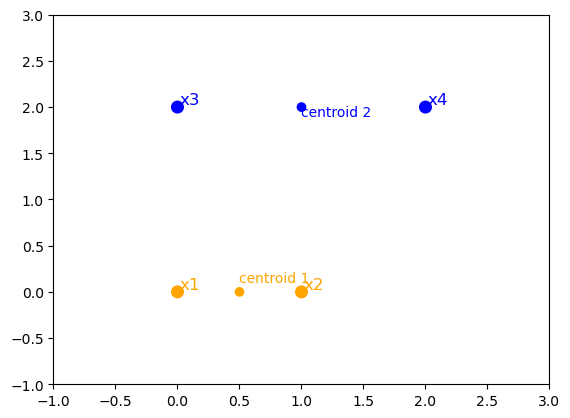

In [74]:
# Assign points to clusters
df.loc[['x1', 'x2'], 'Cluster'] = 1
df.loc[['x3', 'x4'], 'Cluster'] = 2

# Centroids
c1 = updated_centroids[0]
c2 = updated_centroids[1]

# Define cluster colors
cluster_colors = {1: 'orange', 2: 'blue'}

# Plot the points and the centroids
plt.scatter(df['y1'], df['y2'], c = df['Cluster'].map(cluster_colors), s = 70)
plt.scatter([c1[0], c2[0]], [c1[1], c2[1]], color = ['orange', 'blue'])

# Label all points
for label in df.index.values:
    plt.text(df['y1'][label] + 0.1, df['y2'][label], label, fontsize = 12, ha='center', va='bottom', color=cluster_colors[df.loc[label, 'Cluster']])

# Label the centroids
plt.text(c1[0], c1[1] + 0.1, 'centroid 1', color='orange')
plt.text(c2[0], c2[1] - 0.1, 'centroid 2', color='blue')

# Redefine the x and y axis limits (ranges)
plt.xlim(-1, 3)
plt.ylim(-1, 3)

plt.show()

#### c) Compute the silhouette of observation 𝐱1, cluster 𝒄1 and overall solution

In [109]:
def point_silhouette(point_idx, df):
    """
    Silhouette of a point

    args: point index
    df: dataframe with points coordinates and the corresponding cluster
    """

    print('CALCULATING SILHOUETE OF POINT', point_idx)

    # Get clusters
    clusters = df['Cluster']

    points_df = df.drop(['Cluster'], axis = 1)

    # Get point
    point = points_df.loc[point_idx].to_numpy()

    points_df.drop(point_idx, inplace = True)

    # --------------------------- Calculate 'a' --------------------------- #
    point_cluster = clusters[point_idx]

    points_from_cluster = points_df.loc[clusters == point_cluster]
    
    points_from_cluster_idx = points_from_cluster.index.values
    points_from_cluster = points_from_cluster.to_numpy()

    # Calculate pairwise distances using cdist
    distances = np.sqrt(np.sum((points_from_cluster - point) ** 2, axis=1))

    # Convert the distances array to a Pandas Series
    distances_series = pd.Series(distances[0], name='Distance', index = points_from_cluster_idx)

    print('Distances to points in the same cluster:')
    print(distances_series)
    print('---------------------------')

    a = distances.mean()
    print('a =', a)
    print('---------------------------')

    # --------------------------- Calculate 'b' --------------------------- #
    
    # Get all clusters different from the point's cluster
    other_clusters = set(clusters.values)
    other_clusters.remove(point_cluster)

    mean_distances = []

    for cluster in list(other_clusters):
        # Get points from current cluster
        points_from_cluster = points_df.loc[clusters == cluster]

    
        points_from_cluster_idx = points_from_cluster.index.values
        points_from_cluster = points_from_cluster.to_numpy()


        # Calculate pairwise distances using cdist
        distances = np.sqrt(np.sum((points_from_cluster - point) ** 2, axis=1))

        # Convert the distances array to a Pandas Series
        distances_series = pd.Series(distances, name='Distance', index = points_from_cluster_idx)

        print(f'Distances to points in cluster {cluster}:')
        print(distances_series)
        print('---------------------------')

        # Calculate b for current cluster
        b_cluster = distances.mean()
        print(f'b of cluster {cluster} =', b_cluster)
        print('---------------------------')

        mean_distances.append(b_cluster)

    # The final b is the minimum value among all clusters
    b = min(mean_distances)
    print('b =', b)

    if a < b:
        s = 1 - a/b
    else:
        s = b/a - 1

    print(f'Silhouette of point {point_idx} =', s)

    return s

point_silhouette('x1', df)

CALCULATING SILHOUETE OF POINT x1
Distances to points in the same cluster:
x2    1.0
Name: Distance, dtype: float64
---------------------------
a = 1.0
---------------------------
Distances to points in cluster 2.0:
x3    2.000000
x4    2.828427
Name: Distance, dtype: float64
---------------------------
b of cluster 2.0 = 2.414213562373095
---------------------------
b = 2.414213562373095
Silhouette of point x1 = 0.5857864376269049


0.5857864376269049

In [119]:
def cluster_silhouette(cluster_idx, df):
    print(f'CALCULATING SILHOUETTE FOR CLUSTER {cluster_idx}\n')
    
    cluster_df = df[df['Cluster'] == cluster_idx]

    # Get points in cluster
    cluster_points_idx = cluster_df.index.values

    silhouettes = []

    # Calculate silhouette of each point in cluster
    for point_idx in cluster_points_idx:
        silhouettes.append(point_silhouette(point_idx, df))
        print('..................................................')

    cluster_s = sum(silhouettes) / len(silhouettes)

    print(f'Cluster {cluster_idx} silhouette =', cluster_s)

    return cluster_s

cluster_silhouette(1, df)

CALCULATING SILHOUETTE FOR CLUSTER 1

CALCULATING SILHOUETE OF POINT x1
Distances to points in the same cluster:
x2    1.0
Name: Distance, dtype: float64
---------------------------
a = 1.0
---------------------------
Distances to points in cluster 2.0:
x3    2.000000
x4    2.828427
Name: Distance, dtype: float64
---------------------------
b of cluster 2.0 = 2.414213562373095
---------------------------
b = 2.414213562373095
Silhouette of point x1 = 0.5857864376269049
..................................................
CALCULATING SILHOUETE OF POINT x2
Distances to points in the same cluster:
x1    1.0
Name: Distance, dtype: float64
---------------------------
a = 1.0
---------------------------
Distances to points in cluster 2.0:
x3    2.236068
x4    2.236068
Name: Distance, dtype: float64
---------------------------
b of cluster 2.0 = 2.23606797749979
---------------------------
b = 2.23606797749979
Silhouette of point x2 = 0.5527864045000421
.........................................

0.5692864210634735

In [120]:
def silhouette(df):
    clusters_silhouette = []

    # Calculate silhouette of each cluster
    for cluster in set(df['Cluster'].values):
        cluster_s = cluster_silhouette(cluster, df)
        clusters_silhouette.append(cluster_s)
        print('________________________________________________')
    
    # Return the mean
    s = sum(clusters_silhouette) / len(clusters_silhouette)

    print('Overall solution silhouette =', s)

    return s

silhouette(df)

CALCULATING SILHOUETTE FOR CLUSTER 1.0

CALCULATING SILHOUETE OF POINT x1
Distances to points in the same cluster:
x2    1.0
Name: Distance, dtype: float64
---------------------------
a = 1.0
---------------------------
Distances to points in cluster 2.0:
x3    2.000000
x4    2.828427
Name: Distance, dtype: float64
---------------------------
b of cluster 2.0 = 2.414213562373095
---------------------------
b = 2.414213562373095
Silhouette of point x1 = 0.5857864376269049
..................................................
CALCULATING SILHOUETE OF POINT x2
Distances to points in the same cluster:
x1    1.0
Name: Distance, dtype: float64
---------------------------
a = 1.0
---------------------------
Distances to points in cluster 2.0:
x3    2.236068
x4    2.236068
Name: Distance, dtype: float64
---------------------------
b of cluster 2.0 = 2.23606797749979
---------------------------
b = 2.23606797749979
Silhouette of point x2 = 0.5527864045000421
.......................................

0.35112218394981354

### 2. Consider the following data and the initial k centroids be the first k data points.

#### a) Apply k-means with 𝑘 = 2 and 𝑘 = 3

In [130]:
df = pd.DataFrame({'y1': [1, 8, 3, 0, 0, 3], 'y2': [0, 8, 3, 0, 1, 2], 'y3': [0, 4, 0, 1, 0, 1]}, index = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6'])

df

,y1,y2,y3
x1,1,0,0
x2,8,8,4
x3,3,3,0
x4,0,0,1
x5,0,1,0
x6,3,2,1


K = 2

In [131]:
# Initialize the centroids as x1 and x2
c1 = df.iloc[0].to_numpy()
c2 = df.iloc[1].to_numpy()

In [132]:
kmeans(df, [c1, c2])

Distances:
            1          2
x1   0.000000  11.357817
x2  11.357817   0.000000
x3   3.605551   8.124038
x4   1.414214  11.704700
x5   1.414214  11.357817
x6   3.000000   8.366600
------------------------------
Clostest centroid:
x1    1
x2    2
x3    1
x4    1
x5    1
x6    1
dtype: int64
------------------------------
New centroids:
[array([1.4, 1.2, 0.4]), array([8., 8., 4.])]
------------------------------
Update = True
------------------------------
Distances:
            1          2
x1   1.326650  11.357817
x2  10.137061   0.000000
x3   2.441311   8.124038
x4   1.939072  11.704700
x5   1.469694  11.357817
x6   1.886796   8.366600
------------------------------
Clostest centroid:
x1    1
x2    2
x3    1
x4    1
x5    1
x6    1
dtype: int64
------------------------------
New centroids:
[array([1.4, 1.2, 0.4]), array([8., 8., 4.])]
------------------------------
Update = False
------------------------------


[array([1.4, 1.2, 0.4]), array([8., 8., 4.])]

K = 3

In [133]:
# Initialize the centroids as x1, x2 and x3
c1 = df.iloc[0].to_numpy()
c2 = df.iloc[1].to_numpy()
c3 = df.iloc[2].to_numpy()

In [134]:
kmeans(df, [c1, c2, c3])

Distances:
            1          2         3
x1   0.000000  11.357817  3.605551
x2  11.357817   0.000000  8.124038
x3   3.605551   8.124038  0.000000
x4   1.414214  11.704700  4.358899
x5   1.414214  11.357817  3.605551
x6   3.000000   8.366600  1.414214
------------------------------
Clostest centroid:
x1    1
x2    2
x3    3
x4    1
x5    1
x6    3
dtype: int64
------------------------------
New centroids:
[array([0.33333333, 0.33333333, 0.33333333]), array([8., 8., 4.]), array([3. , 2.5, 0.5])]
------------------------------
Update = True
------------------------------
Distances:
            1          2         3
x1   0.816497  11.357817  3.240370
x2  11.445523   0.000000  8.215838
x3   3.785939   8.124038  0.707107
x4   0.816497  11.704700  3.937004
x5   0.816497  11.357817  3.391165
x6   3.214550   8.366600  0.707107
------------------------------
Clostest centroid:
x1    1
x2    2
x3    3
x4    1
x5    1
x6    3
dtype: int64
------------------------------
New centroids:
[array(

[array([0.33333333, 0.33333333, 0.33333333]),
 array([8., 8., 4.]),
 array([3. , 2.5, 0.5])]

### 3. Considering the following data points:

{ 𝑥1 = (4), 𝑥2 = (0), 𝑥3 = (1) }

and a mixture of two normal distributions with the following initialization of likelihoods:

- 𝑃(𝑥 | 𝑘 = 1) = 𝑁(𝑢1 = 1, 𝜎1 = 1)
- 𝑃(𝑥 | 𝑘 = 2) = 𝑁(𝑢2 = 0, 𝜎2 = 1)

and priors: 𝑝 (𝑘 = 1) = 0.5 and 𝑝 (𝑘 = 2) = 0.5

Plot the clusters after one iteration of the EM algorithm.

In [303]:
data = np.array([[4], [0], [1]])


gaussian_1 = norm(loc = 1, scale = 1)
gaussian_2 = norm(loc = 0, scale = 1)

gaussians = [gaussian_1, gaussian_2]

priors = [0.5, 0.5]

In [304]:
clusters_probs = [[], []]

# E-step
for point_idx, point in enumerate(data):
    point_posteriors = []
    
    for cluster, gaussian in enumerate(gaussians):
        # Likelihood for point 'point_idx' and cluster 'cluster'
        likelihood = gaussian.pdf(point)[0]
        posterior = likelihood * priors[cluster]

        point_posteriors.append(posterior)
        
        print(f'Likelihood P(x{point_idx + 1}|cluster_{cluster + 1}) = {likelihood}')
        print('Posterior = Likelihood x Prior', posterior)
        print('---')

    print('Normalized posteriors')
    for cluster_idx, posterior in enumerate(point_posteriors):
        normalized_posterior = point_posteriors[cluster_idx] / sum(point_posteriors)
        
        print(f'P(cluster_{cluster_idx + 1}|x{point_idx + 1}) ~', normalized_posterior)

        # For later...
        clusters_probs[cluster_idx].append(normalized_posterior)

    print('_________________________')

Likelihood P(x1|cluster_1) = 0.0044318484119380075
Posterior = Likelihood x Prior 0.0022159242059690038
---
Likelihood P(x1|cluster_2) = 0.00013383022576488537
Posterior = Likelihood x Prior 6.691511288244268e-05
---
Normalized posteriors
P(cluster_1|x1) ~ 0.9706877692486436
P(cluster_2|x1) ~ 0.02931223075135632
_________________________
Likelihood P(x2|cluster_1) = 0.24197072451914337
Posterior = Likelihood x Prior 0.12098536225957168
---
Likelihood P(x2|cluster_2) = 0.3989422804014327
Posterior = Likelihood x Prior 0.19947114020071635
---
Normalized posteriors
P(cluster_1|x2) ~ 0.37754066879814546
P(cluster_2|x2) ~ 0.6224593312018546
_________________________
Likelihood P(x3|cluster_1) = 0.3989422804014327
Posterior = Likelihood x Prior 0.19947114020071635
---
Likelihood P(x3|cluster_2) = 0.24197072451914337
Posterior = Likelihood x Prior 0.12098536225957168
---
Normalized posteriors
P(cluster_1|x3) ~ 0.6224593312018546
P(cluster_2|x3) ~ 0.37754066879814546
_________________________


In [305]:
# Normalized posteriors
clusters_probs

[[0.9706877692486436, 0.37754066879814546, 0.6224593312018546],
 [0.02931223075135632, 0.6224593312018546, 0.37754066879814546]]

In [308]:
# M-step
for cluster_idx, normalized_posteriors in enumerate(clusters_probs):
    normalized_posteriors = np.array(normalized_posteriors)

    # Update prior
    new_prior = sum(normalized_posteriors) / len(data)

    # Update mean
    new_mean = sum(normalized_posteriors[:, np.newaxis] * data)[0] / sum(normalized_posteriors)

    # Update standard deviation
    new_stdv = np.sqrt(sum(normalized_posteriors[:, np.newaxis] * (data - new_mean)**2)[0] / sum(normalized_posteriors))

    print(f'Prior_{cluster_idx} =', new_prior)
    print(f'Mean_{cluster_idx} =', new_mean)
    print(f'stdev_{cluster_idx} =', new_stdv)
    print('-------------------------------------------')

Prior_0 = 0.6568959230828813
Mean_0 = 2.2861107063723813
stdev_0 = 1.723532382089612
-------------------------------------------
Prior_1 = 0.3431040769171188
Mean_1 = 0.48069922519272335
stdev_1 = 0.7689976484552898
-------------------------------------------


New gaussians plot:

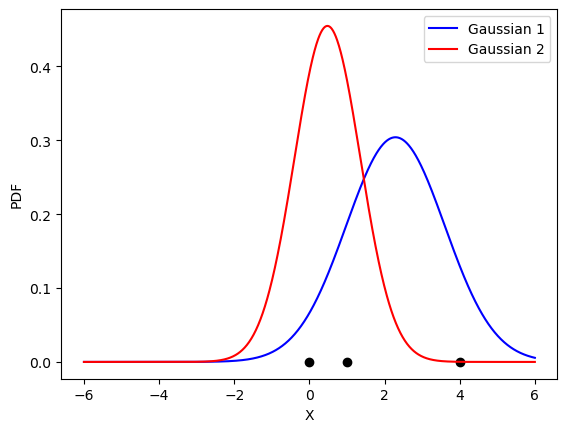

In [206]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the first Gaussian distribution
mean1 = 2.29
variance1 = 1.72

# Parameters for the second Gaussian distribution
mean2 = 0.48
variance2 = 0.769

# Create a range of x values
x = np.linspace(-6, 6, 1000)

# Calculate the PDFs for the two Gaussian distributions
pdf1 = (1 / (np.sqrt(2 * np.pi * variance1))) * np.exp(-(x - mean1)**2 / (2 * variance1))
pdf2 = (1 / (np.sqrt(2 * np.pi * variance2))) * np.exp(-(x - mean2)**2 / (2 * variance2))

# Plot the two Gaussian distributions
plt.plot(x, pdf1, label='Gaussian 1', color='blue')
plt.plot(x, pdf2, label='Gaussian 2', color='red')

# Plot points
plt.scatter(data, [0 for _ in range(len(data))], color = 'black')

# Add labels and a legend
plt.xlabel('X')
plt.ylabel('PDF')
plt.legend()


### 5. Consider the following data points and and a mixture of two multivariate normal distributions with the following likelihoods’ initialization:
𝑃(𝐱 | 𝑘 = 1) = 𝑁(𝑢1 = [2, 2] , 𝜎1 = [[1 0],[0 1]])
𝑃(𝐱 | 𝑘 = 2) = 𝑁(𝑢2 = [0, 0] , 𝜎2 = [[1 0], [0 1]])

and priors: 𝑝 (𝑘 = 1) = 0.6 and 𝑝 (𝑘 = 2) = 0.4

#### a) Perform one expectation maximization iteration

In [280]:
data = np.array([[2, 2], [0, 2], [0, 0]])

gaussian_1 = multivariate_normal(mean = [2, 2], cov = [[1, 0], [0, 1]])
gaussian_2 = multivariate_normal(mean = [0, 0], cov = [[1, 0], [0, 1]])

gaussians = [gaussian_1, gaussian_2]

priors = [0.6, 0.4]

In [281]:
clusters_probs = [[], []]

# E-step
for point_idx, point in enumerate(data):
    point_posteriors = []
    
    for cluster, gaussian in enumerate(gaussians):
        # Likelihood for point 'point_idx' and cluster 'cluster'
        likelihood = gaussian.pdf(point)
        posterior = likelihood * priors[cluster]

        point_posteriors.append(posterior)
        
        print(f'Likelihood P(x{point_idx + 1}|cluster_{cluster + 1}) = {likelihood}')
        print('Posterior = Likelihood x Prior', posterior)
        print('---')

    print('Normalized posteriors')
    for cluster_idx, posterior in enumerate(point_posteriors):
        normalized_posterior = point_posteriors[cluster_idx] / sum(point_posteriors)
        
        print(f'P(cluster_{cluster_idx + 1}|x{point_idx + 1}) ~', normalized_posterior)

        # For later...
        clusters_probs[cluster_idx].append(normalized_posterior)

    print('_________________________')

Likelihood P(x1|cluster_1) = 0.15915494309189535
Posterior = Likelihood x Prior 0.09549296585513721
---
Likelihood P(x1|cluster_2) = 0.002915024465028194
Posterior = Likelihood x Prior 0.0011660097860112775
---
Normalized posteriors
P(cluster_1|x1) ~ 0.9879368700291202
P(cluster_2|x1) ~ 0.012063129970879785
_________________________
Likelihood P(x2|cluster_1) = 0.021539279301848634
Posterior = Likelihood x Prior 0.01292356758110918
---
Likelihood P(x2|cluster_2) = 0.021539279301848634
Posterior = Likelihood x Prior 0.008615711720739454
---
Normalized posteriors
P(cluster_1|x2) ~ 0.6
P(cluster_2|x2) ~ 0.4
_________________________
Likelihood P(x3|cluster_1) = 0.002915024465028194
Posterior = Likelihood x Prior 0.0017490146790169164
---
Likelihood P(x3|cluster_2) = 0.15915494309189535
Posterior = Likelihood x Prior 0.06366197723675814
---
Normalized posteriors
P(cluster_1|x3) ~ 0.026738849661062998
P(cluster_2|x3) ~ 0.973261150338937
_________________________


In [282]:
clusters_probs

[[0.9879368700291202, 0.6, 0.026738849661062998],
 [0.012063129970879785, 0.4, 0.973261150338937]]

In [302]:
# M-step
for cluster_idx, normalized_posteriors in enumerate(clusters_probs):
    normalized_posteriors = np.array(normalized_posteriors)

    posteriors_sum = np.sum(normalized_posteriors)

    # New prior
    new_prior = posteriors_sum / len(data)

    # New mean
    new_mean = np.matmul(normalized_posteriors, data) / posteriors_sum

    # New cov matrix
    aux = np.multiply((data - new_mean).T, np.array([normalized_posteriors]))
    new_cov = np.matmul(aux, data - new_mean) / posteriors_sum

    print(f'New prior of cluster {cluster_idx + 1}:', new_prior)
    print(f'New mean of cluster {cluster_idx + 1}:', new_mean)
    print(f'New cov matrix of cluster {cluster_idx + 1}:\n', new_cov)
    print('---------------------------------------------------------')

New prior of cluster 1: 0.5382252398967278
New mean of cluster 1: [1.22369694 1.96688022]
New cov matrix of cluster 1:
 [[0.94995968 0.04052857]
 [0.04052857 0.06514263]]
---------------------------------------------------------
New prior of cluster 2: 0.4617747601032723
New mean of cluster 2: [0.0174156  0.59489772]
New cov matrix of cluster 2:
 [[0.03452791 0.02447071]
 [0.02447071 0.83589215]]
---------------------------------------------------------


#### c) Sketch the points and clusters

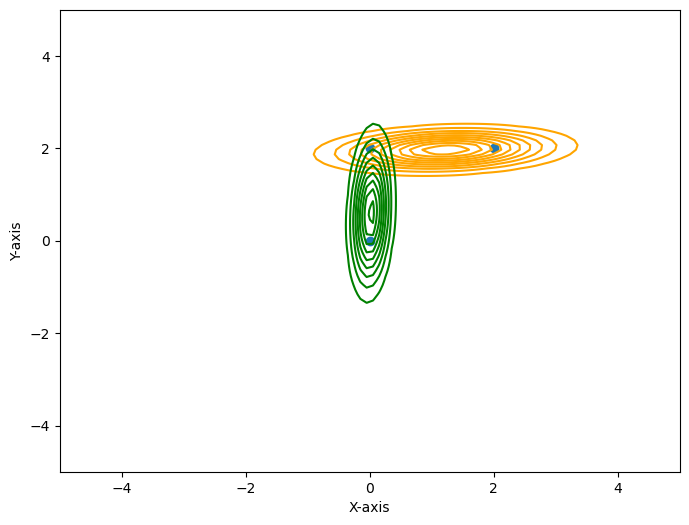

In [301]:
# Parameters for cluster 1 gaussian
mean1 = np.array([1.22369694, 1.96688022])
cov1 = np.array([[0.94995968, 0.04052857], [0.04052857, 0.06514263]])

# Parameters for cluster 2 gaussian
mean2 = np.array([0.0174156, 0.59489772])
cov2 = np.array([[0.03452791, 0.02447071], [0.02447071, 0.83589215]])

# Create meshgrid of points for visualization
x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))
pos = np.dstack((x, y))

# Create gaussians
pdf1 = multivariate_normal.pdf(pos, mean1, cov1)
pdf2 = multivariate_normal.pdf(pos, mean2, cov2)

# Plot gaussians contours
plt.figure(figsize=(8, 6))
plt.contour(x, y, pdf1, levels=10, colors = 'orange')
plt.contour(x, y, pdf2, levels=10, colors = 'green')

# Plot the points
plt.scatter(data[:, 0], data[:, 1])

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.show()